![image.png](https://i.imgur.com/a3uAqnb.png)


# 🧠 Attention-Based Transformer Classifier: IMDb Sentiment Analysis

This notebook demonstrates how to fine-tune a pretrained Transformer model (specifically `distilbert-base-uncased`) for binary text classification using the IMDb movie reviews dataset. The workflow follows a clean and modular structure, making it easy to extend or adapt to other NLP tasks.

### 📌 Objectives:
- Load and preprocess a real-world text classification dataset.
- Use Hugging Face’s 🤗 Transformers and Datasets libraries for efficient NLP modeling.
- Define a custom `TextDataset` for tokenized inputs.
- Fine-tune a pretrained Transformer model using the Hugging Face `Trainer` API.
- Track training progress and visualize evaluation metrics.
- Perform inference on custom inputs and interpret predictions.

### 🧰 Key Features:
- Uses the IMDb dataset with clear train/val/test splits.
- Implements custom configuration and logging.
- Includes early stopping and metric tracking (F1, Accuracy, etc.).
- Easy-to-use inference function for testing new text samples.

By the end of this notebook, you will have a fully trained binary sentiment classifier ready to predict whether a given movie review is **positive** or **negative**.


### 🧱 Imports and Setup

This cell imports all the necessary libraries for model development, including:
- **PyTorch** and **Transformers** for deep learning and NLP tasks.
- **Datasets** from Hugging Face to load datasets.
- **Scikit-learn** for evaluation metrics.
- **Matplotlib** and **Seaborn** for visualization.
- **TQDM** for progress bars.
- **Warnings** are suppressed for a cleaner output.

Additionally:
- Random seeds are set for reproducibility.
- Output directories are created to store trained models and logs.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
from datasets import load_dataset
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Create output directory if it doesn't exist
import os
os.makedirs("./fine_tuned_model", exist_ok=True)
os.makedirs("./fine_tuned_model/logs", exist_ok=True)

### ⚙️ Configuration Parameters

Defines a `Config` class that centralizes key parameters for model training and evaluation:
- **Model settings**: Pretrained model name, maximum token length, number of labels.
- **Training settings**: Batch size, learning rate, number of epochs, weight decay, warmup ratio.
- **Data settings**: Proportions for train, validation, and test splits.
- **Output settings**: Directory paths and logging frequencies.

This structure allows easy modification and readability.


In [2]:
# =============================================================================
# CONFIGURATION
# =============================================================================

class Config:
    """Configuration class for fine-tuning parameters"""
    
    # Model settings
    MODEL_NAME = "distilbert-base-uncased"
    MAX_LENGTH = 512
    NUM_LABELS = 2  # Adjust based on your task
    
    # Training settings
    BATCH_SIZE = 32
    LEARNING_RATE = 2e-5
    NUM_EPOCHS = 5
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01
    
    # Data settings
    TRAIN_SIZE = 0.8
    VAL_SIZE = 0.1
    TEST_SIZE = 0.1
    
    # Output settings
    OUTPUT_DIR = "./fine_tuned_model"
    SAVE_STEPS = 100
    EVAL_STEPS = 100
    LOGGING_STEPS = 100

config = Config()
print(f"✅ Configuration loaded - Model: {config.MODEL_NAME}")

✅ Configuration loaded - Model: distilbert-base-uncased


### 📦 Custom TextDataset Class

Defines a `TextDataset` class for tokenizing and formatting the raw text data into a format compatible with Hugging Face transformers:
- Uses the `tokenizer` to convert texts into `input_ids` and `attention_mask`.
- Returns tokenized inputs and the corresponding label tensors.
- Applies padding and truncation to a fixed max length.


In [3]:
# =============================================================================
# DATA PREPARATION
# =============================================================================

class TextDataset(Dataset):
    """Custom dataset class for text classification"""
    
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


### 🤖 Setup Model and Tokenizer

Initializes the tokenizer and model:
- Loads a pretrained model and tokenizer using Hugging Face's Transformers library.
- Adds a padding token if it's missing.
- Loads the classification model with the specified number of labels.
- Moves the model to the appropriate device (CPU/GPU).


In [4]:
# =========================================================================|====
# MODEL SETUP
# =============================================================================

def setup_model_and_tokenizer():
    """Initialize tokenizer and model"""
    print(f"🤖 Loading model and tokenizer: {config.MODEL_NAME}")
    
    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
    
    # Add padding token if it doesn't exist
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    
    # Load model for sequence classification
    model = AutoModelForSequenceClassification.from_pretrained(
        config.MODEL_NAME,
        num_labels=config.NUM_LABELS
    )
    
    # Move to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    print(f"✅ Model loaded on device: {device}")
    return tokenizer, model, device



### 📥 Load IMDb Dataset and Prepare Splits

- Loads the IMDb dataset (binary sentiment classification) using Hugging Face `load_dataset`.
- Tokenizes and converts train/test data into `TextDataset` objects.
- Splits the training data into training and validation subsets.
- Also initializes the model, tokenizer, and sets up the device.


In [5]:
raw_dataset = load_dataset("imdb")
train_texts = raw_dataset['train']['text'] 
train_labels = raw_dataset['train']['label']
test_texts = raw_dataset['test']['text']
test_labels = raw_dataset['test']['label']

print(f"✅ Data loaded - Train samples: {len(train_texts)}, Test samples: {len(test_texts)}")

# Create tokenizer and model
tokenizer, model, device = setup_model_and_tokenizer()

# Create datasets
print("🔄 Creating datasets...")
train_dataset = TextDataset(train_texts, train_labels, tokenizer, config.MAX_LENGTH)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, config.MAX_LENGTH)

# Split train into train/validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

print(f"✅ Datasets created - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

✅ Data loaded - Train samples: 25000, Test samples: 25000
🤖 Loading model and tokenizer: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded on device: cuda
🔄 Creating datasets...
✅ Datasets created - Train: 22500, Val: 2500, Test: 25000


### 🧠 Trainer Setup and Evaluation Metrics

- Defines a `compute_metrics` function to calculate accuracy, precision, recall, and F1 score.
- Initializes Hugging Face `TrainingArguments` to configure:
  - Epochs, batch sizes, learning rate, logging frequency, and early stopping.
- Sets up the `Trainer` class with:
  - Model, training/validation datasets, evaluation metrics, and early stopping callback.


In [6]:
# =============================================================================
# TRAINING SETUP
# =============================================================================

def compute_metrics(eval_pred):
    """Compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir=config.OUTPUT_DIR,
    num_train_epochs=config.NUM_EPOCHS,
    per_device_train_batch_size=config.BATCH_SIZE,
    per_device_eval_batch_size=config.BATCH_SIZE,
    learning_rate=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY,
    warmup_ratio=config.WARMUP_RATIO,
    logging_dir=f'{config.OUTPUT_DIR}/logs',
    lr_scheduler_type="cosine",
    eval_strategy="steps",
    logging_strategy="steps",
    eval_steps=config.EVAL_STEPS,
    logging_steps=config.EVAL_STEPS,  
    save_steps=config.SAVE_STEPS,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to=[],
)


# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)] #based on F1 score aka 'metric_for_best_model'
)

print("✅ Training setup complete!")

✅ Training setup complete!


### 🚀 Train the Model

- Triggers the training process using `trainer.train()`.
- Saves the fine-tuned model and tokenizer to the specified output directory.


In [7]:
# =============================================================================
# TRAINING
# =============================================================================

def train_model():
    """Train the model"""
    print("🚀 Starting training...")
    
    # Train
    trainer.train()
    
    # Save final model
    trainer.save_model(config.OUTPUT_DIR)
    tokenizer.save_pretrained(config.OUTPUT_DIR)
    
    print(f"✅ Training complete! Model saved to {config.OUTPUT_DIR}")


train_model()

🚀 Starting training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.686900,0.649134,0.786000,0.785928,0.786674,0.786000
200,0.413200,0.257632,0.899200,0.899144,0.899808,0.899200
300,0.275200,0.242571,0.907200,0.906973,0.910552,0.907200
400,0.276900,0.227907,0.912400,0.912318,0.914454,0.912400
500,0.249200,0.206563,0.921600,0.921593,0.921968,0.921600
600,0.245900,0.222805,0.912800,0.912673,0.914717,0.912800
700,0.243400,0.200287,0.923200,0.923187,0.923344,0.923200
800,0.195900,0.207253,0.926000,0.926001,0.926004,0.926000
900,0.171700,0.214542,0.923600,0.923550,0.924395,0.923600
1000,0.171400,0.205852,0.924800,0.924749,0.925628,0.924800


✅ Training complete! Model saved to ./fine_tuned_model


### 📊 Training Curves Visualization

- Extracts log history from the `Trainer` state.
- Plots:
  - **Training & Evaluation Loss** over steps.
  - **Evaluation Accuracy** over steps.
- Helps in diagnosing underfitting/overfitting and tracking training progress.


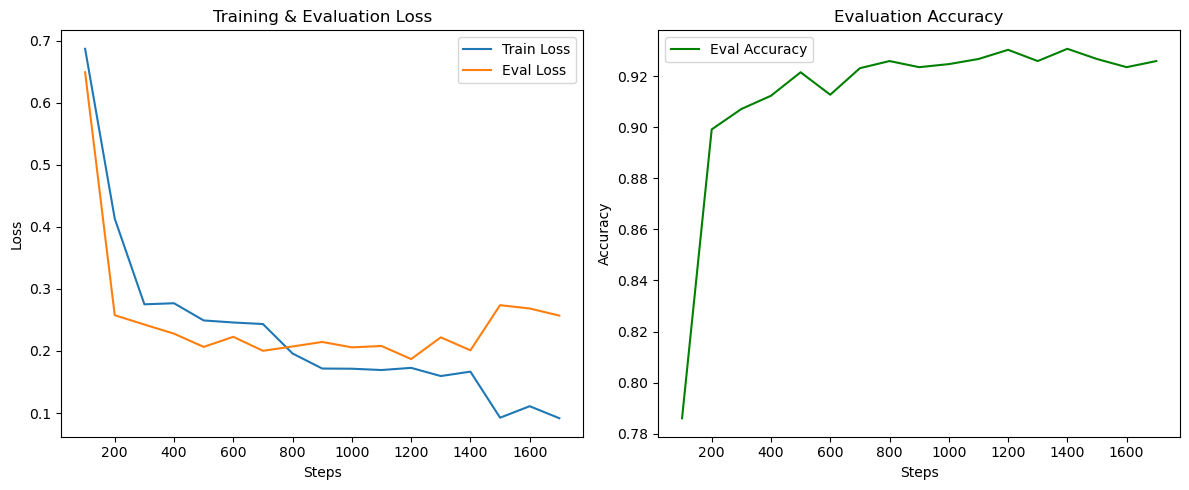

In [8]:
# Extract logs
log_history = trainer.state.log_history

# Prepare metrics
train_loss = []
eval_loss = []
eval_accuracy = []
steps = []

for log in log_history:
    step = log.get("step")
    if "loss" in log:
        train_loss.append(log["loss"])
        steps.append(step)
    if "eval_loss" in log:
        eval_loss.append(log["eval_loss"])
    if "eval_accuracy" in log:
        eval_accuracy.append(log["eval_accuracy"])

# Plotting
plt.figure(figsize=(12, 5))

# 📉 Training & Eval Loss
plt.subplot(1, 2, 1)
plt.plot(steps[:len(train_loss)], train_loss, label='Train Loss')
plt.plot(steps[:len(eval_loss)], eval_loss, label='Eval Loss')
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()

# ✅ Evaluation Accuracy
plt.subplot(1, 2, 2)
plt.plot(steps[:len(eval_accuracy)], eval_accuracy, label='Eval Accuracy', color='green')
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


### ✅ Evaluate on Test Set

- Evaluates the trained model on the test dataset using `trainer.evaluate`.
- Prints out final evaluation metrics such as accuracy, loss, and F1 score.


In [9]:
# =============================================================================
# EVALUATION
# =============================================================================
print("📊 Evaluating model...")
    
# Evaluate on test set
test_results = trainer.evaluate(test_dataset)
    
print("Test Results:")
for key, value in test_results.items():
    print(f"  {key}: {value:.4f}")
    

📊 Evaluating model...


Test Results:
  eval_loss: 0.1973
  eval_accuracy: 0.9298
  eval_f1: 0.9298
  eval_precision: 0.9299
  eval_recall: 0.9298
  eval_runtime: 125.2861
  eval_samples_per_second: 199.5430
  eval_steps_per_second: 6.2420
  epoch: 2.4148


### 🔍 Predict on a Single Input Text

Defines a utility function `predict_single_text` to:
- Tokenize a single input string.
- Run the model in evaluation mode (no gradients).
- Apply softmax to get confidence scores.
- Return the predicted class and its confidence.


In [10]:
def predict_single_text(text, model, tokenizer, device):
    """Make prediction on a single text"""
    model.eval()
    
    # Tokenize
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=config.MAX_LENGTH,
        return_tensors='pt'
    ).to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(predictions, dim=1).item()
        confidence = predictions[0][predicted_class].item()
    
    return predicted_class, confidence

### 🔮 Inference on Example Sentences

- Provides a few example review sentences to demonstrate the inference capability of the model.
- Uses the `predict_single_text` function to classify each as Positive or Negative.
- Displays the prediction along with confidence scores.


In [11]:
# =============================================================================
# INFERENCE EXAMPLES
# =============================================================================

def run_inference_examples():
    """Run some inference examples"""
    print("🔮 Running inference examples...")
    
    sample_texts = [
        "This product is amazing! I love it so much.",
        "Terrible quality, would not recommend to anyone.",
        "It's okay, nothing special but does the job.",
        "Outstanding performance and great value for money!"
    ]
    
    for text in sample_texts:
        pred_class, confidence = predict_single_text(text, model, tokenizer, device)
        sentiment = "Positive" if pred_class == 1 else "Negative"
        print(f"Text: '{text[:50]}...'")
        print(f"Prediction: {sentiment} (confidence: {confidence:.3f})\n")

### ▶️ Run Inference Examples

- Calls the `run_inference_examples()` function to demonstrate the model’s prediction behavior in action.
- Useful for quick manual inspection of how well the model understands sentiment.


In [12]:
# Run example inference (with untrained model for demo)
run_inference_examples()


🔮 Running inference examples...
Text: 'This product is amazing! I love it so much....'
Prediction: Positive (confidence: 0.996)

Text: 'Terrible quality, would not recommend to anyone....'
Prediction: Negative (confidence: 0.979)

Text: 'It's okay, nothing special but does the job....'
Prediction: Negative (confidence: 0.662)

Text: 'Outstanding performance and great value for money!...'
Prediction: Positive (confidence: 0.991)



### Contributed by: Yazan Alshoibi